In [1]:
import re

In [1]:
import sys
import os

In [2]:
script_path = "configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper.py"

In [3]:
script_path = script_path[:-3]

In [4]:
script_path

'configs/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [5]:
new_path = script_path.replace("configs", "../results")

In [6]:
new_path

'../results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [7]:
with open(new_path + "/test_file.txt", 'w') as f:
    f.write("test")

In [7]:
new_path = os.path.dirname(new_path)

NameError: name 'os' is not defined

In [8]:
import_name = new_path + "/"

In [9]:
script = __import__(import_name)

ModuleNotFoundError: No module named 'results/continuous/skolik_arch/schuld_datareup/localskolik_outscaling/ZZ_obs/skolik_optimal_hyper'

In [1]:
import tensorflow as tf

In [190]:
import pennylane as qml
import numpy as np

In [236]:
def variational_layer(wires, params):
    [[qml.RY(params[2*i], wires[i]),
     qml.RZ(params[(i*2)+1], wires[i])] for i in range(len(wires))]

In [237]:
dev = qml.device("default.qubit", wires = 4)
params = [1,2,3,4,5,6,7,8]
@qml.qnode(dev)
def circuit(params):
    variational_layer(range(4), params)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

print(qml.draw(circuit)(params))

0: ──RY(1.00)──RZ(2.00)─┤ ╭<Z@Z>
1: ──RY(3.00)──RZ(4.00)─┤ ╰<Z@Z>
2: ──RY(5.00)──RZ(6.00)─┤       
3: ──RY(7.00)──RZ(8.00)─┤       


In [192]:
def entangling_layer(wires):
    qml.CZ(wires = [0,1])
    qml.CZ(wires = [1,2])
    qml.CZ(wires = [2,3])
    qml.CZ(wires = [3,0])

In [193]:
def data_encoding(wires, data):
    [qml.RX(data, wires[i], id = f"x_{i}") for i in range(len(wires))]

In [194]:
dev = qml.device("default.qubit", wires = 4)

num_layers = 2

@qml.qnode(dev)
def schuld_datareup(params, data):
    for l in range(num_layers):
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
        data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [195]:
@qml.qnode(dev)
def basic_datareup(params, data):
    for l in range(num_layers-1):
        data_encoding(range(4), data)
        variational_layer(range(4), params[l])
        entangling_layer(range(4))
    data_encoding(range(4), data)
    variational_layer(range(4), params[num_layers-1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [196]:
data = np.random.uniform(-0.05,0.05)
params_schuld =[[np.random.uniform(0, np.pi) for i in range(8)] for j in range(num_layers + 1)]
params_basic = params_schuld[:-1]

In [197]:
print(qml.draw(schuld_datareup)(params_schuld, data))

0: ──RY(2.19)──RZ(0.11)─╭●───────╭Z──RX(0.04)──RY(0.41)──RZ(3.07)─╭●───────╭Z──RX(0.04)──RY(2.54)
1: ──RY(2.07)──RZ(1.71)─╰Z─╭●────│───RX(0.04)──RY(2.45)──RZ(0.75)─╰Z─╭●────│───RX(0.04)──RY(1.67)
2: ──RY(2.78)──RZ(0.89)────╰Z─╭●─│───RX(0.04)──RY(0.48)──RZ(1.05)────╰Z─╭●─│───RX(0.04)──RY(0.33)
3: ──RY(0.93)──RZ(0.32)───────╰Z─╰●──RX(0.04)──RY(1.37)──RZ(0.16)───────╰Z─╰●──RX(0.04)──RY(0.41)

───RZ(0.56)─┤ ╭<Z@Z>
───RZ(2.01)─┤ ╰<Z@Z>
───RZ(1.89)─┤       
───RZ(0.53)─┤       


In [198]:
print(qml.draw(basic_datareup)(params_basic, data))

0: ──RX(0.04)──RY(2.19)──RZ(0.11)─╭●───────╭Z──RX(0.04)──RY(0.41)──RZ(3.07)─┤ ╭<Z@Z>
1: ──RX(0.04)──RY(2.07)──RZ(1.71)─╰Z─╭●────│───RX(0.04)──RY(2.45)──RZ(0.75)─┤ ╰<Z@Z>
2: ──RX(0.04)──RY(2.78)──RZ(0.89)────╰Z─╭●─│───RX(0.04)──RY(0.48)──RZ(1.05)─┤       
3: ──RX(0.04)──RY(0.93)──RZ(0.32)───────╰Z─╰●──RX(0.04)──RY(1.37)──RZ(0.16)─┤       


In [199]:
from pennylane.fourier import coefficients, circuit_spectrum
freqs_schuld = circuit_spectrum(schuld_datareup)(params_schuld, data)
freqs_basic = circuit_spectrum(basic_datareup)(params_basic, data)

In [200]:
for k,v in freqs_schuld.items():
    print(k, ":", v)

for k,v in freqs_basic.items():
    print(k, ":", v)

x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]
x_0 : [-2.0, -1.0, 0, 1.0, 2.0]
x_1 : [-2.0, -1.0, 0, 1.0, 2.0]
x_2 : [-2.0, -1.0, 0, 1.0, 2.0]
x_3 : [-2.0, -1.0, 0, 1.0, 2.0]


In [204]:
from functools import partial
partial_schuld_circuit = partial(schuld_datareup, params_schuld)
partial_basic_circuit = partial(basic_datareup, params_basic)

coeffs_schuld = coefficients(partial_schuld_circuit, 1, 2)
coeffs_basic = coefficients(partial_basic_circuit, 1, 2)

In [205]:
coeffs_schuld

array([-0.03367574+0.j        ,  0.10102612+0.00853097j,
        0.03985307+0.0265832j ,  0.03985307-0.0265832j ,
        0.10102612-0.00853097j])

In [206]:
coeffs_basic

array([-0.00970938+0.j        , -0.01529039+0.00103236j,
       -0.04175327-0.05338724j, -0.04175327+0.05338724j,
       -0.01529039-0.00103236j])

In [207]:
from pennylane.fourier.visualize import *
import matplotlib.pyplot as plt

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

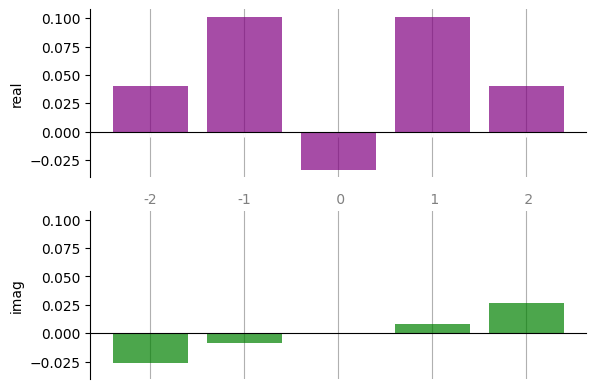

In [208]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_schuld, 1, ax)

array([<AxesSubplot: ylabel='real'>, <AxesSubplot: ylabel='imag'>],
      dtype=object)

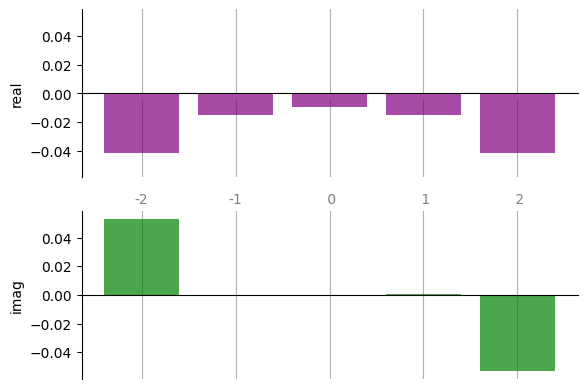

In [209]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True) # Set up the axes
bar(coeffs_basic, 1, ax)

In [98]:
@qml.qnode(dev)
def simple_circuit(x):
    qml.RX(x[0], wires=0)
    qml.RY(x[0], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(0))

In [99]:
coeffs = coefficients(simple_circuit, 1, 2)

In [291]:
dev = qml.device("default.qubit", wires = 1)

@qml.qnode(dev)
def simple_circuit(params, data):
    qml.RX(params[0], wires=0)
    qml.RY(data[0], wires = 0, id = "x")
    qml.RX(params[1], wires = 0)
    qml.RY(data[1], wires = 0, id = "x")
    qml.RX(params[2], wires = 0)
    return qml.expval(qml.PauliZ(0))

In [294]:
data = [0,1]
params = [0.5,0.3,0.8]

In [295]:
simple_freqs = circuit_spectrum(simple_circuit)(params, data)

In [296]:
for k,v in simple_freqs.items():
    print(k, ":", v)

x : [-2.0, -1.0, 0, 1.0, 2.0]


In [297]:
from functools import partial

In [301]:
partial_circuit = partial(simple_circuit, params)
coeffs = coefficients(partial_circuit,2,1,lowpass_filter=True)

In [302]:
coeffs

array([[-0.32855821+0.j, -0.04935468+0.j, -0.04935468+0.j],
       [-0.09302078+0.j,  0.29888181+0.j, -0.00682701+0.j],
       [-0.09302078+0.j, -0.00682701+0.j,  0.29888181+0.j]])

In [287]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y

In [288]:
def f(x):
    return np.array([simple_circuit(params,x_) for x_ in x])

In [289]:
coeffs = fourier_coefficients(f, 1)

In [290]:
coeffs

array([-0.14167993+0.00000000e+00j,  0.41919332-1.28197512e-16j])

In [1]:
import pennylane as qml
import numpy as np

In [168]:
params = [np.random.uniform(0, np.pi) for i in range(6)]

In [181]:
dev = qml.device("default.qubit", wires = 2)

@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [182]:
results = circuit(params)
results = results[0] * results[1]
results

tensor(0.00106099, requires_grad=True)

In [183]:
@qml.qnode(dev)
def circuit(params):
    qml.RY(params[0], wires = 0)
    qml.RY(params[1], wires = 1)
    qml.RX(params[2], wires = 0)
    qml.RX(params[3], wires = 1)
    qml.RZ(params[4], wires = 0)
    qml.RZ(params[5], wires = 1)
    #qml.CNOT(wires = [0,1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [184]:
result = circuit(params)
result

tensor(-0.03021677, requires_grad=True)

In [210]:
from fourier_analysis.pennylane_operations import *

In [211]:
operations = QMLOperations()

In [218]:
dev = qml.device("default.qubit", wires = 4)

@qml.qnode(dev)
def circuit():
    operations.skolik_entangling_layer(range(4))
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

In [220]:
print(qml.draw(circuit)())

0: ─╭●───────╭●─┤ ╭<Z@Z>
1: ─╰Z─╭●────│──┤ ╰<Z@Z>
2: ────╰Z─╭●─│──┤       
3: ───────╰Z─╰Z─┤       


In [221]:
def operations():
    qml.Hadamard(wires = 0)

In [241]:
def circuit():
    operations()
    return qml.sample(qml.PauliZ(0))

In [244]:
dev = qml.device("default.qubit", wires = 1, shots = 5)
qnode = qml.QNode(circuit, dev)


In [245]:
qnode()

tensor([ 1,  1,  1, -1,  1], requires_grad=True)